### **Automated Customer Complaints Classification Leveraging NLP and Machinne Learning.**

#### **Introduction:**
In today's fast-paced and ever evolving world, businesses strive to provide excellent customer service to stand out and retain their customer base. One of the critical aspect of any business is customer service, making sure that, the businesses are efficiently handling customer complaints. The rapid advancements in technology have changed the way businesses handle customer support, with automated complaint classification systems emerging as a major tool. These systems, powered by sophisticated machine learning algorithms and artificial intelligence, enable companies to efficiently categorize and address customer grievances, significantly improving response times, service quality and streamlining the resolution process.

#### **Dataset Description**

The dataset we are using for this task, is a collection of complaint tickets from a financial institution, stored in JSON format. This dataset serves as a rich repository of textual data, reflecting a large number of issues and interactions between customers and the institution. These texts are customer-initiated complaints or queries related to different financial products and services offered by the institution. The data shows what customers complain about and how happy they are with financial services. It helps understand what problems the company faces and how satisfied customers are.

##### **Data Structure and Attributes**
Each record in the dataset represents a single complaint, encapsulated in a structured format with multiple fields. Key attributes include:
- **_index and _type**: These fields denote the index and type of the data source, respectively, typically signifying the internal database or category of complaints within the institution.

- **_id**: A unique identifier for each complaint, facilitating easy retrieval and reference.
- **_score**: This could represent a relevance or priority score assigned to the complaint, although it appears uniformly set to 0.0 in the sample, suggesting it may not be actively used or is placeholder data.
- **_source.tags**: Tags or labels that may have been applied to categorize the complaint, such as 'Servicemember' in one of the entries, indicating specific customer segments or issues.
- **_source.zip_code**: The postal code of the complainant, providing geographical context and allowing for regional analysis of complaint patterns.
- **_source.complaint_id**: Another unique identifier for the complaint, likely used for internal tracking and management.
- **_source.issue**: A brief description of the complaint or the primary issue raised by the customer.
- **_source.date_received**: The date and time when the complaint was filed, crucial for understanding the temporal distribution of complaints.
- **_source.state**: The state from which the complaint originated, further adding to the geographical analysis capability.
- Additional fields capturing the company's response, the medium through which the complaint was submitted, and detailed descriptions of the complaint.

**USE CASES OF DATA**
- Customer Service Improvement: Identifying common complaint themes can help the institution address systemic issues and improve customer service quality.
- Product and Service Enhancement: Analysis of complaint patterns can guide product development and service enhancements, aligning offerings more closely with customer needs.
- Risk Management: Understanding the nature and frequency of complaints related to fraud and disputes can aid in refining risk management strategies and fraud prevention mechanisms.
- Market and Regional Analysis: Geographical data points allow for regional analysis of complaints, helping to identify market-specific issues or opportunities for targeted interventions.

In [ ]:
!pip install spacy

In [ ]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 29.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
# import modules
import json  # load json
import numpy as np  # numerical ops
import pandas as pd  # data manipulation
import re  # text process
import nltk  # text process
import spacy  # text process
import string  # text process
import unicodedata  # unicode ops
import warnings  # warnings
import seaborn as sns  # plotting
import matplotlib.pyplot as plt  # plotting
from wordcloud import WordCloud, STOPWORDS  # word cloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer  # text features
from sklearn.decomposition import NMF  # matrix factor
from pprint import pprint  # pretty print
from tqdm import tqdm  # progress bar
from sklearn.model_selection import train_test_split  # data split
from sklearn.ensemble import RandomForestClassifier  # random forest
from sklearn.linear_model import LogisticRegression  # logistic regression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc  # metrics
from sklearn.preprocessing import label_binarize  # label binarize
from sklearn.multiclass import OneVsRestClassifier  # multiclass
from xgboost import XGBClassifier  # xgboost
from itertools import cycle  # cycle iter
import itertools  # itertools
import gensim
from gensim.models import Nmf  # gensim nmf
from gensim.models.coherencemodel import CoherenceModel  # coherence model
from gensim.corpora import Dictionary  # gensim dict

In [ ]:
# config settings
warnings.filterwarnings('ignore')  #ignore warnings
pd.set_option('display.max_colwidth', None, 'display.max_columns', None, 'display.max_rows', None)  #pandas config
tqdm.pandas()  # progress apply

In [ ]:
# initialize spacy
nlp = spacy.load('en_core_web_sm')  # load model

Load Data

In [ ]:
json_file_path = "complaints.json"

with open(json_file_path, "r") as json_file:
    complaints_data = json.load(json_file)
    complaints_df = pd.json_normalize(complaints_data)

complaints_df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


Data Exploartion and Preparation

In [ ]:
complaints_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [ ]:
complaints_df.describe()

,_score
count,78313.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


In [ ]:
complaints_df.describe(include='object').T

,count,unique,top,freq
_index,78313,1,complaint-public-v2,78313
_type,78313,1,complaint,78313
_id,78313,78313,3211475,1
_source.tags,10900,3,Older American,6103
_source.zip_code,71556,9442,606XX,472
_source.complaint_id,78313,78313,3211475,1
_source.issue,78313,154,"Loan modification,collection,foreclosure",9743
_source.date_received,78313,3444,2015-08-27T12:00:00-05:00,82
_source.state,76322,62,CA,14009
_source.consumer_disputed,78313,3,N/A,35683


In [ ]:
complaints_df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [ ]:
def rename_columns(column_name):
    if column_name.startswith('_source.'):
        return column_name[len('_source.'):]
    elif column_name.startswith('_'):
        return column_name[1:]  # remove leading underscore
    return column_name
complaints_df.columns = [rename_columns(col) for col in complaints_df.columns]
complaints_df.columns

Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')

In [ ]:
#filter out rows where 'complaint_what_happened' is either blank or NaN
complaints_df = complaints_df[complaints_df['complaint_what_happened'].replace('', np.nan).notnull()]

In [ ]:
complaints_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21072 entries, 1 to 78312
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   index                      21072 non-null  object 
 1   type                       21072 non-null  object 
 2   id                         21072 non-null  object 
 3   score                      21072 non-null  float64
 4   tags                       3816 non-null   object 
 5   zip_code                   16427 non-null  object 
 6   complaint_id               21072 non-null  object 
 7   issue                      21072 non-null  object 
 8   date_received              21072 non-null  object 
 9   state                      20929 non-null  object 
 10  consumer_disputed          21072 non-null  object 
 11  product                    21072 non-null  object 
 12  company_response           21072 non-null  object 
 13  company                    21072 non-null  object 


Complaints Over Time Analysis

In [ ]:
complaints_df['date_received'] = pd.to_datetime(complaints_df['date_received'])
min_date = complaints_df['date_received'].min()
print(f"Minimum date: {min_date}")
# Find the maximum date
max_date = complaints_df['date_received'].max()
print(f"Maximum date: {max_date}")

Minimum date: 2015-03-19 12:00:00-05:00
Maximum date: 2021-03-14 12:00:00-05:00


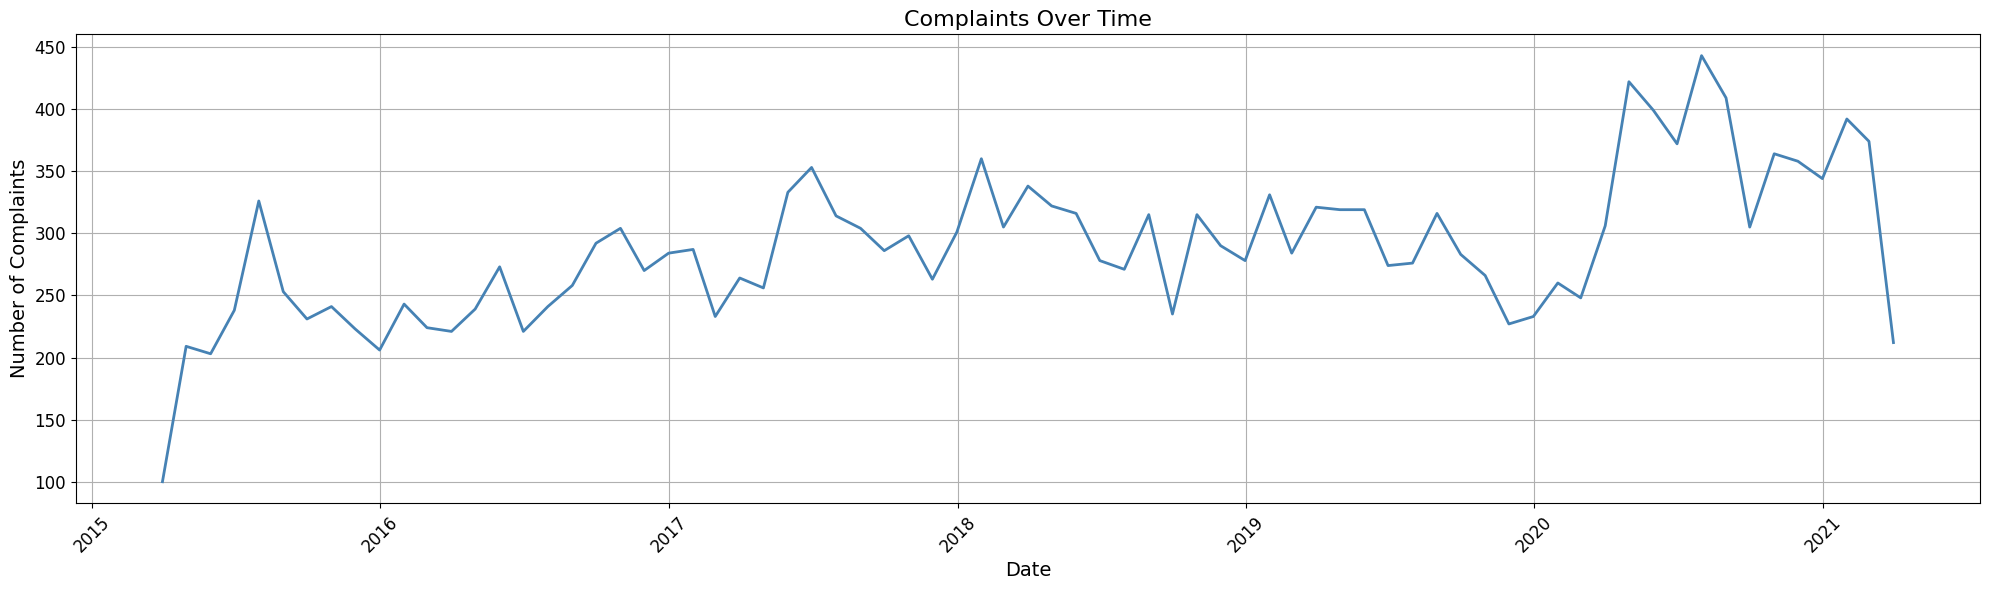

In [ ]:

monthly_complaints = complaints_df.set_index('date_received').resample('M').size()

plt.figure(figsize=(20, 6))
plt.plot(monthly_complaints.index, monthly_complaints, color='steelblue', linestyle='-', linewidth=2)

plt.title('Complaints Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of Complaints', fontsize=14)

plt.grid(True)
plt.xticks(rotation=45)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.show()

Complaints by State

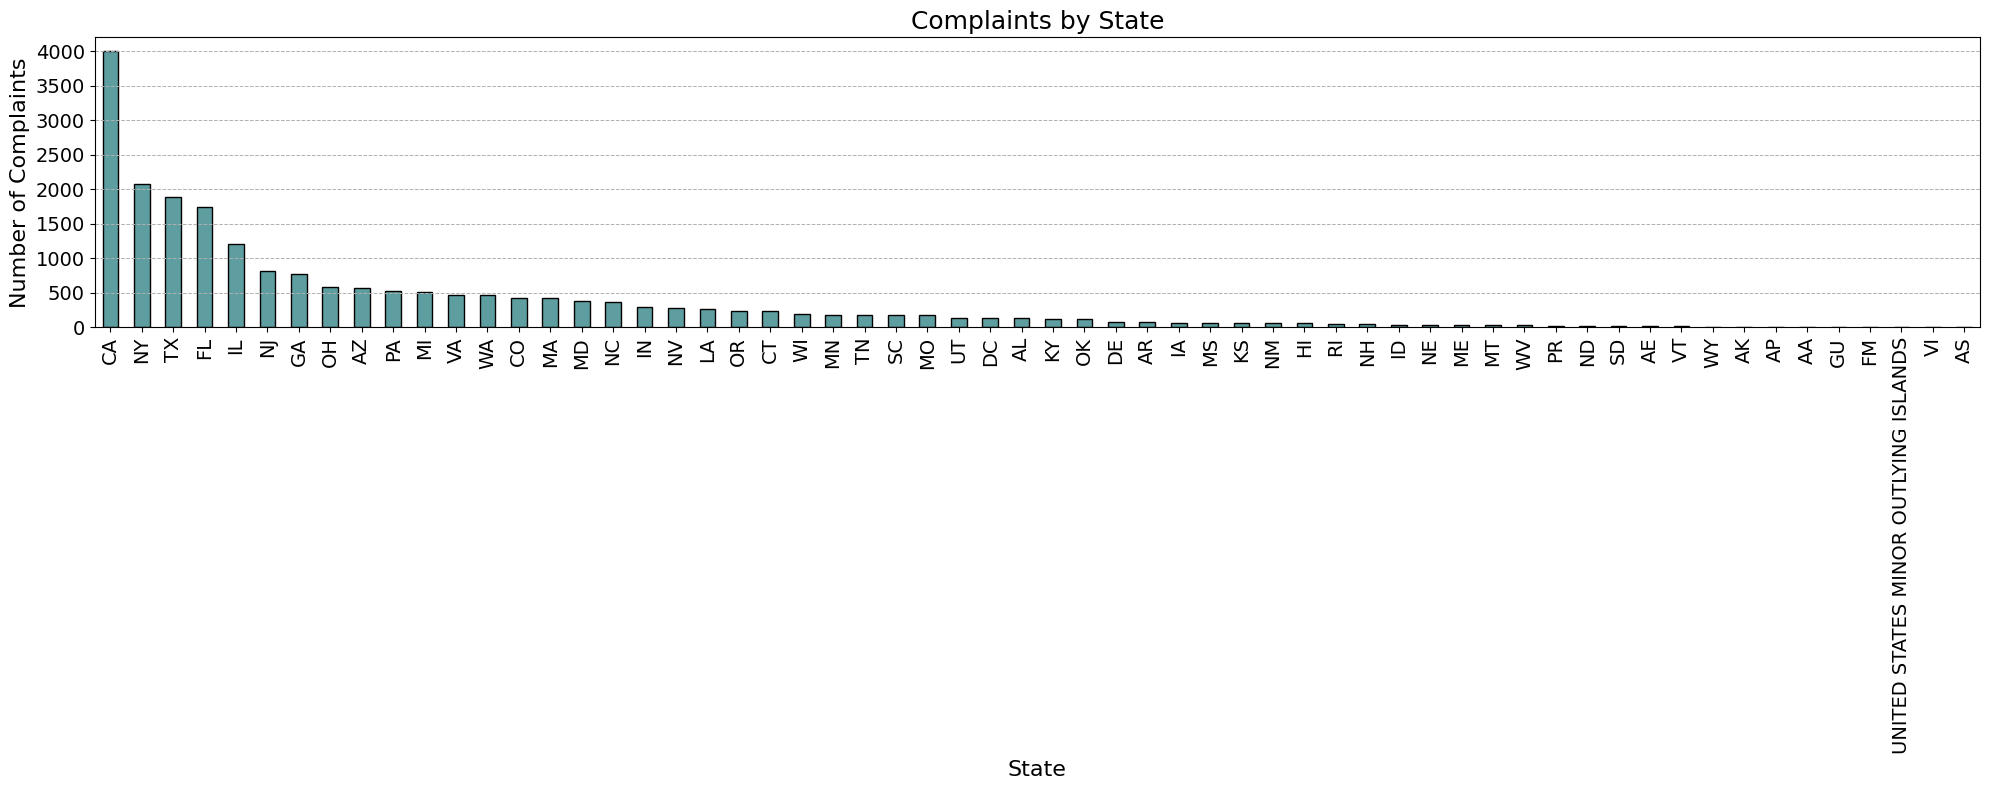

In [ ]:
state_complaints = complaints_df['state'].value_counts()

plt.figure(figsize=(20, 8))
state_complaints.plot(kind='bar', color='cadetblue', edgecolor='black')
plt.title('Complaints by State', fontsize=18)
plt.xlabel('State', fontsize=16)
plt.ylabel('Number of Complaints', fontsize=16)
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.xticks(rotation=90, fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

Complaint by Issue

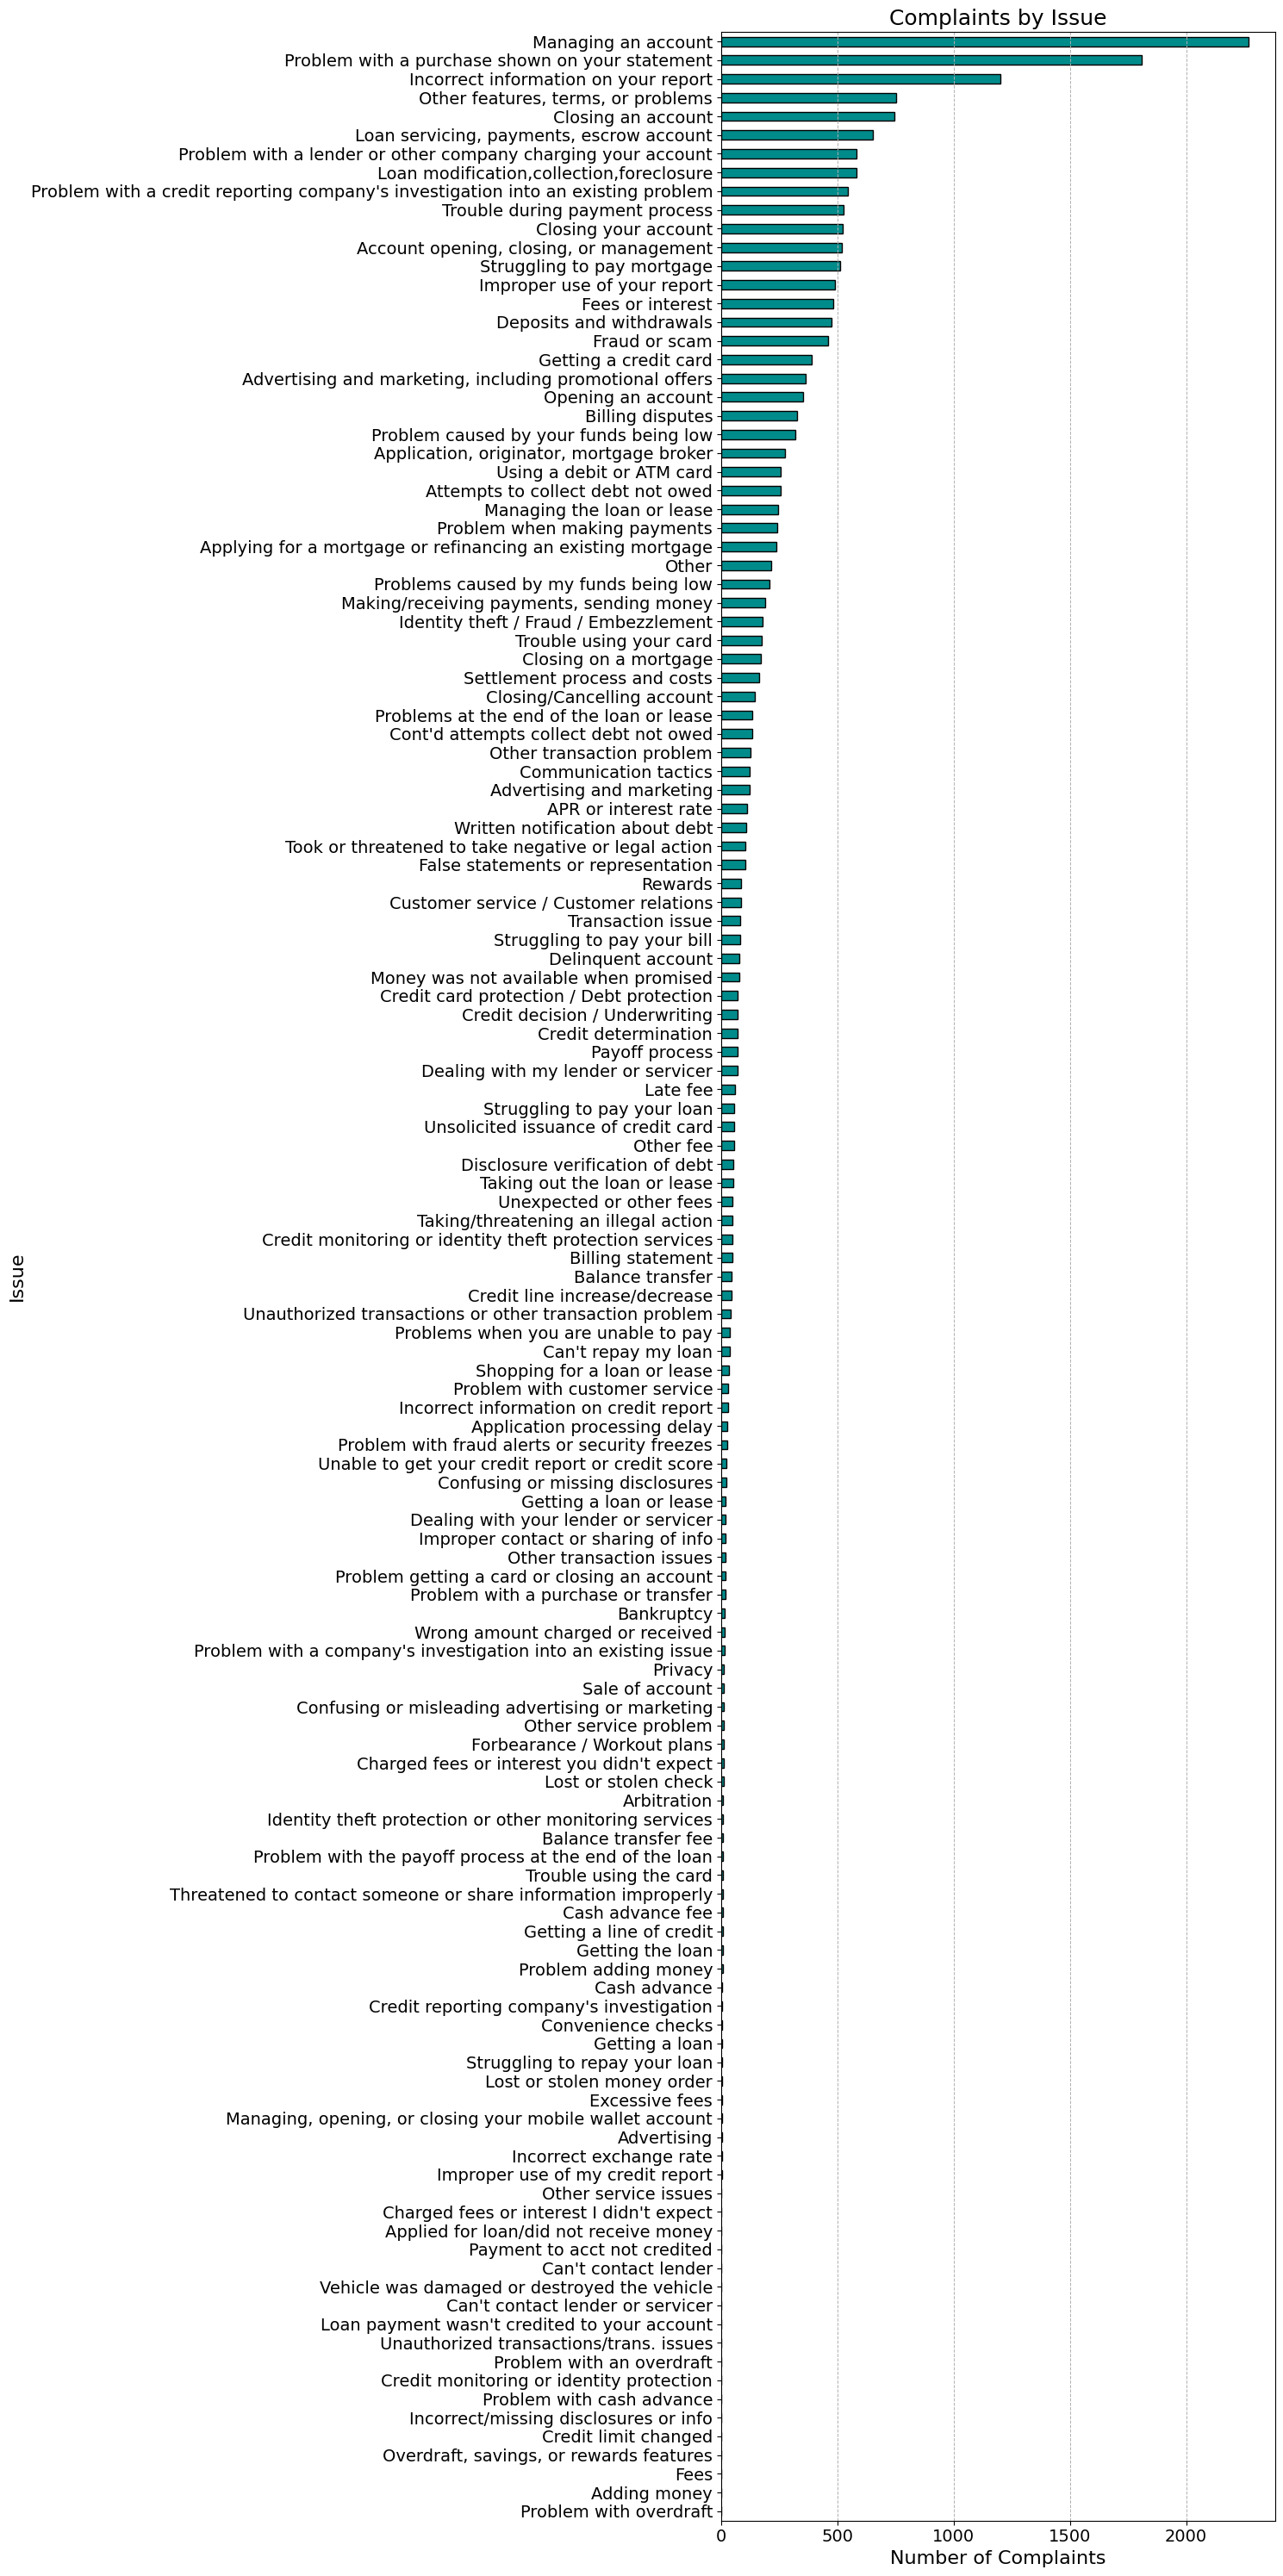

In [ ]:
# Calculate the number of complaints per issue
issue_complaints = complaints_df['issue'].value_counts()
plt.figure(figsize=(15, 30))
issue_complaints.plot(kind='barh', color='darkcyan', edgecolor='black')
plt.title('Complaints by Issue', fontsize=18)
plt.xlabel('Number of Complaints', fontsize=16)
plt.ylabel('Issue', fontsize=16)

plt.grid(axis='x', linestyle='--', linewidth=0.7)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Complaints by Company Response

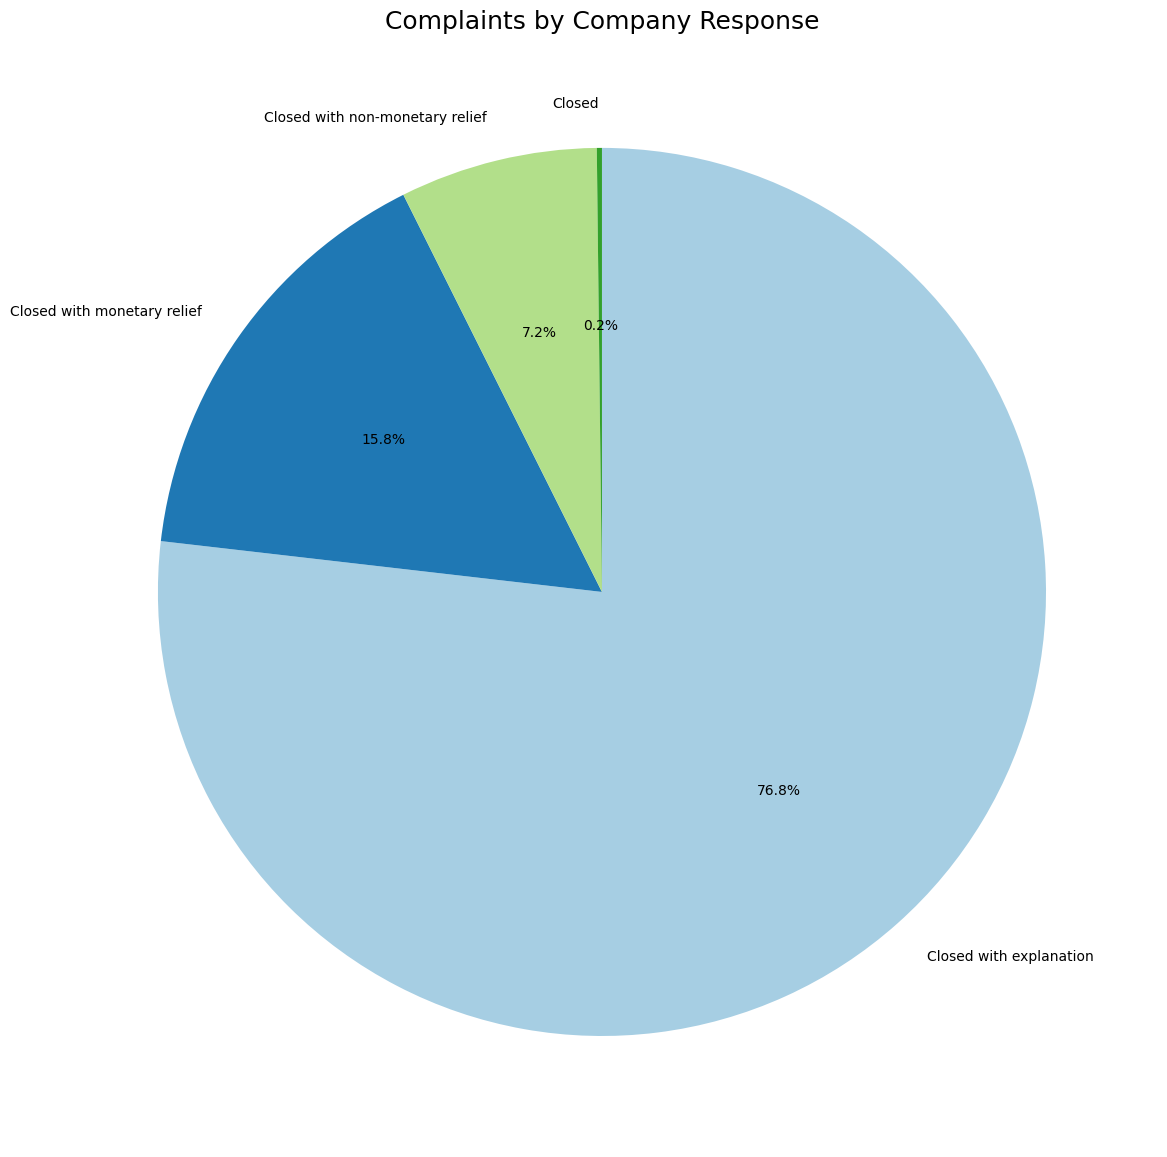

In [ ]:
company_response_counts = complaints_df['company_response'].value_counts()

plt.figure(figsize=(12, 12))
colors = plt.cm.Paired(range(len(company_response_counts)))
company_response_counts.plot(kind='pie', autopct='%1.1f%%', colors=colors, startangle=90, counterclock=False)
plt.title('Complaints by Company Response', fontsize=18)
plt.ylabel('')
plt.tight_layout()
plt.show()

Complaints by Product

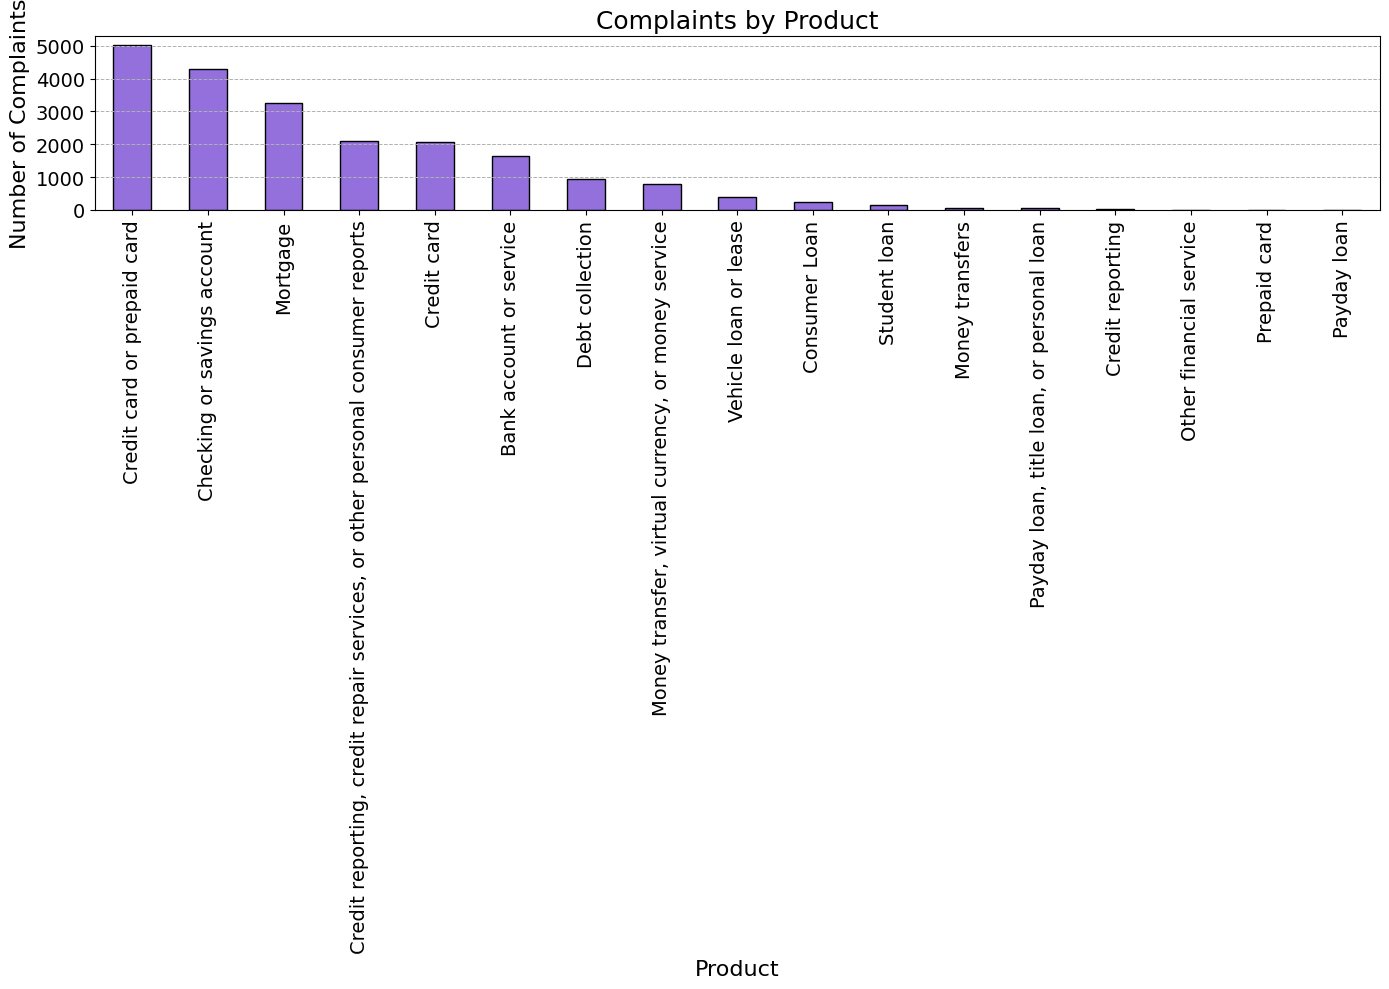

In [ ]:
product_complaints = complaints_df['product'].value_counts()

plt.figure(figsize=(14, 10))
product_complaints.plot(kind='bar', color='mediumpurple', edgecolor='black')
plt.title('Complaints by Product', fontsize=18)
plt.xlabel('Product', fontsize=16)
plt.ylabel('Number of Complaints', fontsize=16)
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.xticks(rotation=90, fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

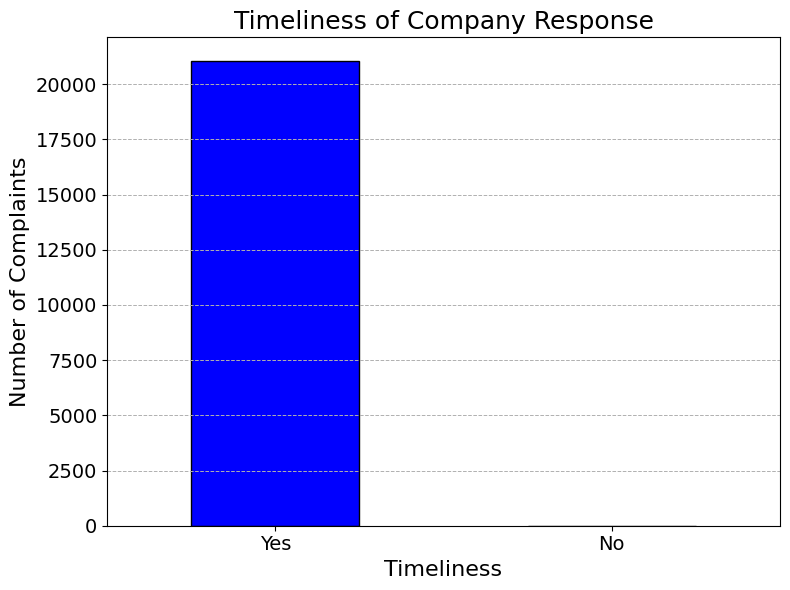

In [ ]:
timely_counts = complaints_df['timely'].value_counts()
plt.figure(figsize=(8, 6))
timely_counts.plot(kind='bar', color='blue', edgecolor='black')
plt.title('Timeliness of Company Response', fontsize=18)
plt.xlabel('Timeliness', fontsize=16)
plt.ylabel('Number of Complaints', fontsize=16)
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.xticks(rotation=0, fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

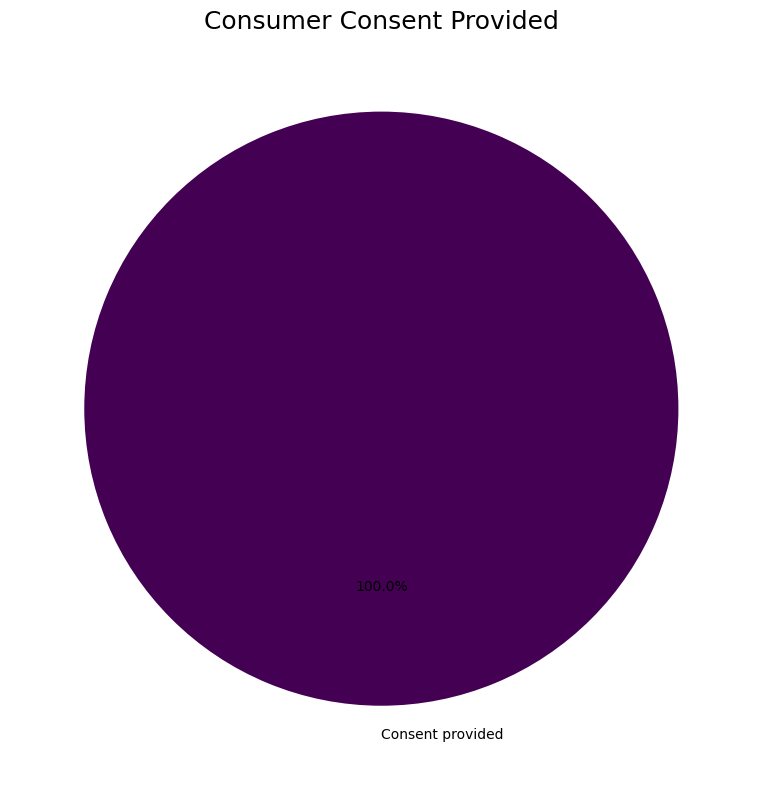

In [ ]:
consent_counts = complaints_df['consumer_consent_provided'].value_counts()
plt.figure(figsize=(8, 8))
colors = plt.cm.viridis(range(len(consent_counts)))
consent_counts.plot(kind='pie', autopct='%1.1f%%', colors=colors, startangle=90, counterclock=False)
plt.title('Consumer Consent Provided', fontsize=18)
plt.ylabel('')

plt.tight_layout()
plt.show()